In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-value-prediction-challenge/sample_submission.csv
/kaggle/input/santander-value-prediction-challenge/train.csv
/kaggle/input/santander-value-prediction-challenge/test.csv


# LightGBM, XGBoost and CatBoost

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

In [3]:
train_df = pd.read_csv('../input/santander-value-prediction-challenge/train.csv')
test_df = pd.read_csv('../input/santander-value-prediction-challenge/test.csv')

train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
train_df.shape

(4459, 4993)

In [5]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
test_df.shape

(49342, 4992)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


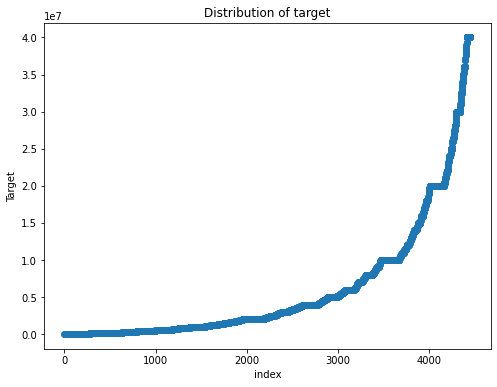

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index')
plt.ylabel('Target')
plt.title('Distribution of target')
plt.show()

In [9]:
train_df.isnull().sum()

ID           0
target       0
48df886f9    0
0deb4b6a8    0
34b15f335    0
            ..
71b203550    0
137efaa80    0
fb36b89d9    0
7e293fbaf    0
9fc776466    0
Length: 4993, dtype: int64

In [10]:
remove_cols = []
for col in train_df.columns:
    if col != 'ID' and col != 'target':
        if train_df[col].std() == 0:
            remove_cols.append(col)
            
train_df.drop(remove_cols, axis=1, inplace=True)
test_df.drop(remove_cols, axis=1, inplace=True)

print(train_df.shape)

(4459, 4737)


In [11]:
# remove duplicate columns
train_df = train_df.loc[:, ~train_df.columns.duplicated()]
print('After removing duplicating columns, ', train_df.shape)

After removing duplicating columns,  (4459, 4737)


In [12]:
encoded_train_df = pd.get_dummies(train_df)
encoded_train_df.shape

(4459, 9195)

In [13]:
sparse_encoded_train_df = pd.get_dummies(train_df, sparse=True)
sparse_encoded_train_df.shape

(4459, 9195)

In [14]:
# converting the encoded columns into sparse arrays 
def convert_to_sparse_array(df,exclude_columns=[]):
    df = df.copy()
    exclude_columns = set(exclude_columns)
    for (c_name, c_data) in df.iteritems():
        if c_name in exclude_columns:
            continue
        df[c_name] = pd.SparseArray(c_data.values, dtype='uint8')
    return df

train_df_sparse_array = convert_to_sparse_array(encoded_train_df)
print(train_df_sparse_array.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.SparseArray class is deprecated and will be removed from pandas in a future version. Use pandas.arrays.SparseArray instead.
  


(4459, 9195)


In [15]:
train_df_sparse_array.head()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,ID_ff3d0e888,ID_ff3e1f24c,ID_ff7b7c367,ID_ff7be29d2,ID_ff7cdeb16,ID_ff85154c8,ID_ffb6b3f4f,ID_ffcf61eb6,ID_ffea67e98,ID_ffeb15d25
0,128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,192,0,0,0,0,0,0,0,0,192,...,0,0,0,0,0,0,0,0,0,0
2,128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,128,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def drop_sparse(train, test):
    column_list_drop = [i for i in train.columns if not i in ['ID', 'target']]
    for l in column_list_drop:
        if len(np.unique(train[l])) < 2:
            train.drop(l, axis=1, inplace = True)
            test.drop(l, axis=1, inplace=True)
    return train, test

train_df, test_df = drop_sparse(train_df, test_df)

In [17]:
train_df.shape

(4459, 4737)

In [18]:
X_train = train_df.drop(['ID', 'target'], axis=1)
y_train = np.log1p(train_df['target'].values)
X_test_og = test_df.drop('ID', axis=1)

train_x, validation_x, train_y, validation_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# LightGBM Model Training

In [22]:
def lgbm(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 100,
        "learning_rate": 0.001,
        "bagging_fraction": 0.6,
        "feature_fraction": 0.6,
        "bagging_frequency": 6,
        "bagging_seed": 42,
        "verbosity": -1,
        "seed": 42
    }
    
    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}
    model_light_gbm = lgb.train(params, lg_train, 5000, 
                                valid_sets=[lg_train, lg_validation], 
                                early_stopping_rounds=100, 
                                verbose_eval=150, 
                                evals_result=evals_result_lgbm)
    pred_test_light_gbm = np.expm1(model_light_gbm.predict(test_x, num_iteration=model_light_gbm.best_iteration))
    return pred_test_light_gbm, model_light_gbm, evals_result_lgbm

In [23]:
# Training and output of LGBM model
predictions_test_y_lgbm, model_lgbm, evals_result = lgbm(train_x, train_y, validation_x, validation_y, X_test_og)

print('output of LightGBM Model training.')

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.66447	valid_1's rmse: 1.63998
[300]	training's rmse: 1.57647	valid_1's rmse: 1.59273
[450]	training's rmse: 1.49838	valid_1's rmse: 1.55444
[600]	training's rmse: 1.42899	valid_1's rmse: 1.5229
[750]	training's rmse: 1.36605	valid_1's rmse: 1.49779
[900]	training's rmse: 1.30903	valid_1's rmse: 1.47722
[1050]	training's rmse: 1.25715	valid_1's rmse: 1.46109
[1200]	training's rmse: 1.20994	valid_1's rmse: 1.44797
[1350]	training's rmse: 1.16675	valid_1's rmse: 1.43745
[1500]	training's rmse: 1.12708	valid_1's rmse: 1.42923
[1650]	training's rmse: 1.09046	valid_1's rmse: 1.42251
[1800]	training's rmse: 1.05679	valid_1's rmse: 1.41778
[1950]	training's rmse: 1.02548	valid_1's rmse: 1.41419
[2100]	training's rmse: 0.995928	valid_1's rmse: 1.4113
[2250]	training's rmse: 0.96824	valid_1's rmse: 1.40915
[2400]	training's rmse: 0.941909	valid_1's rmse

In [24]:
predictions_test_y_lgbm

array([1396058.19813598, 1770587.4606388 , 2384302.71873373, ...,
       1060010.79976986,  357173.71415508, 2035282.98804646])

In [25]:
# Feature importance in LightGBM
gain_light_gbm = model_lgbm.feature_importance('gain')
feature_imp_light_gbm = pd.DataFrame({'feature': model_lgbm.feature_name(),
                                     'split': model_lgbm.feature_importance('split'),
                                     'gain': 100 * gain_light_gbm / gain_light_gbm.sum()}).sort_values('gain', ascending=False)
print(feature_imp_light_gbm[:50])

        feature  split      gain
4135  f190486d6   6790  6.931083
2378  58e2e02e6   6115  4.920505
3470  eeb9cd3aa   5559  4.045366
2617  9fd594eec   4122  3.176494
4025  15ace8c9f   5251  3.011257
8     20aa07010   3674  1.897522
3576  58232a6fb   3506  1.457728
834   6eef030c1   3736  1.278441
1459  b43a7cfd5   4265  1.250970
2690  fb0f5dbfe   4565  1.124296
3666  491b9ee45   2672  1.045985
1484  024c577b9   2917  1.013810
4348  1702b5bf0   3069  0.937800
4190  f74e8f13d   3565  0.930632
566   66ace2992   3089  0.887587
4513  c47340d97   3228  0.879622
3727  d6bb78916   3369  0.867906
2082  58e056e12   3565  0.833137
863   fc99f9426   2466  0.772764
3816  adb64ff71   2670  0.747453
4033  5c6487af1   2540  0.728116
4458  190db8488   3137  0.724895
3224  ced6a7e91   1676  0.658301
3796  ed8ff54b5    757  0.643408
2137  241f0f867   2461  0.641603
3872  2288333b4   1234  0.626267
537   26fc93eb7   2553  0.604212
3891  50e4f96cf   1138  0.589821
2619  fb387ea33    992  0.577047
828   6786